# Time Series Project
By: Anna Vu (July 2021)

Planning: I'm going to predict average temperature for a major city. After observing our file, I've decided I will be looking at average temperatures in Chicago, IL (USA) and see if I can predict them for future use. 

In [1]:
# Imports

# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

#functions
import climate_functions as c

## Acquire and Prepare

I'm bringing in a dataset of global land temperatures based on major cities. To prepare it for use, I did the following:

 - Renamed columns
 - Only extracted for data in Chicago, IL
 - Interpolated missing values
 - Date was an object column, changed it to datetime
 - Set the date as the index
 - Made a year and month column based off of the date column
 - Set it for years 1900 to 2013

In [2]:
df = c.get_temp_data()

In [3]:
df = c.prepare_temp_data(df)

In [4]:
df

,avg_temp,AverageTemperatureUncertainty,city,country,Latitude,Longitude,year,month
date,,,,,,,,
1900-01-01,1.905,0.472,Chicago,United States,42.59N,87.27W,1900,1
1900-02-01,-3.409,0.894,Chicago,United States,42.59N,87.27W,1900,2
1900-03-01,-0.282,0.625,Chicago,United States,42.59N,87.27W,1900,3
1900-04-01,8.347,0.659,Chicago,United States,42.59N,87.27W,1900,4
1900-05-01,13.055,0.251,Chicago,United States,42.59N,87.27W,1900,5
...,...,...,...,...,...,...,...,...
2013-05-01,13.734,0.863,Chicago,United States,42.59N,87.27W,2013,5
2013-06-01,17.913,0.669,Chicago,United States,42.59N,87.27W,2013,6
2013-07-01,21.914,0.322,Chicago,United States,42.59N,87.27W,2013,7


## Explore

<AxesSubplot:xlabel='year'>

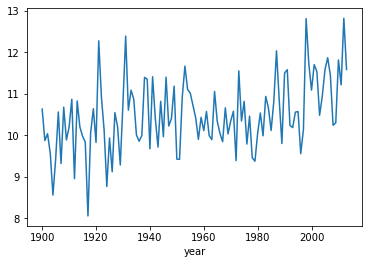

In [5]:
#how does average temperature change over the years?
df.groupby('year').avg_temp.mean().plot()

<AxesSubplot:xlabel='month'>

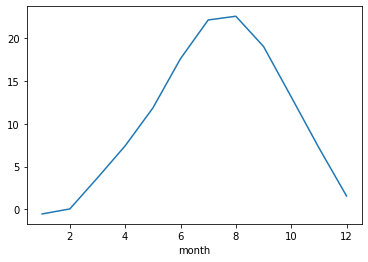

In [6]:
#how does average temperature change over the months within a year?
df.groupby('month').avg_temp.mean().plot()

<AxesSubplot:>

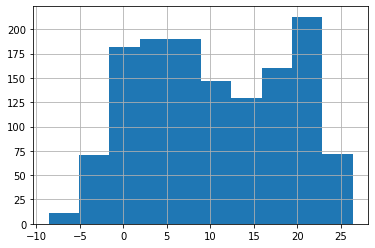

In [7]:
#average temp distribution
df.avg_temp.hist()

<AxesSubplot:xlabel='year'>

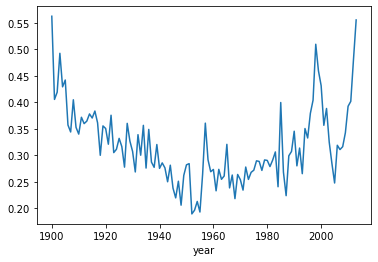

In [8]:
#out of curiosity, how does the unvertainty change over all of these years?
df.groupby('year').AverageTemperatureUncertainty.mean().plot()

Takeaways:
 - Average Temperature seems to be increasing each year
 - Uncertainty was higher at earlier years, dropped around 1950 and went back up. 
 - Coldest months are at the beginning/end of the year, warmest are around June to August

Now, I'm going to split my data. Since I only want to focus on average temperatures, I'll drop the rest of the columns

In [9]:
#Only going to look at date, and average temperature
df = df[['avg_temp']]

In [10]:
#50% of our data goes to train
train_size = int(len(df)*0.5)

In [11]:
#30% goes to validate
validate_size = int(len(df)*0.3)

In [12]:
#test gets 20% aka what is left over
test_size = int(len(df)-train_size - validate_size)

In [13]:
#establishing that the end of the validate set is the length of train size and validate size combined
validate_end_index = train_size + validate_size

In [14]:
#train
train = df[:train_size]
#validate
validate = df[train_size:validate_end_index]
#test
test = df[validate_end_index:]

In [15]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


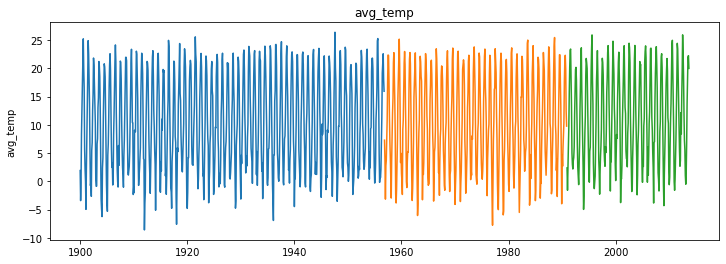

In [16]:
#let's have a look at our data and its splits
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    
    plt.ylabel(col)
    plt.title(col)

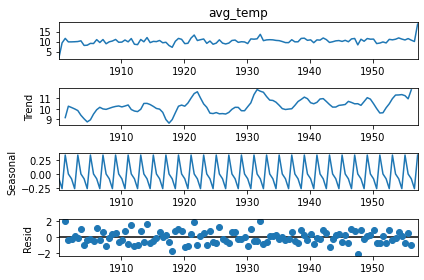

In [17]:
#seasonal decomposition - 6 months
sm.tsa.seasonal_decompose(train.avg_temp.resample('6M').mean()).plot()
None

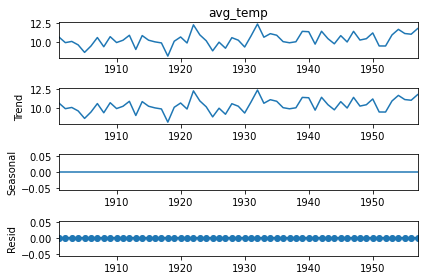

In [18]:
#seasonal decomposition - 1 year
sm.tsa.seasonal_decompose(train.avg_temp.resample('Y').mean()).plot()
None

In [19]:
#further exploration with average temperature
y = train.avg_temp

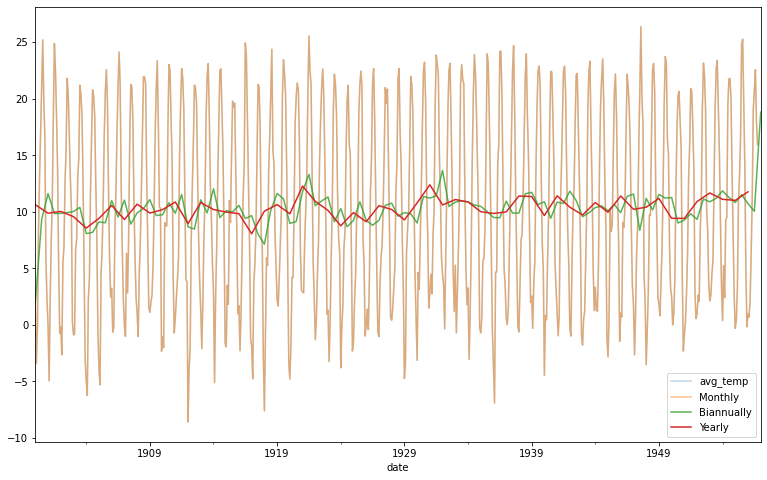

In [20]:
#average temperatures across various time periods
plt.figure(figsize=(13,8))
ax = y.plot(alpha=.3)
y.resample('M').mean().plot(ax=ax, alpha=.5, label='Monthly')
y.resample('6M').mean().plot(ax=ax, alpha=.8, label='Biannually')
y.resample('Y').mean().plot(ax=ax, label='Yearly')
ax.legend()
plt.show()

[Text(0.5, 1.0, 'Average Temperature Over Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temperature')]

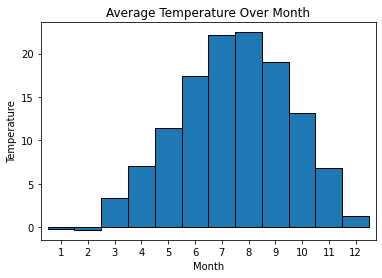

In [21]:
#average temperatures by month but in a bar chart
ax = y.groupby(y.index.month).mean().plot.bar(width=1,ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature Over Month', xlabel='Month',ylabel='Temperature')

[Text(0.5, 0, 't'), Text(0, 0.5, 't+1')]

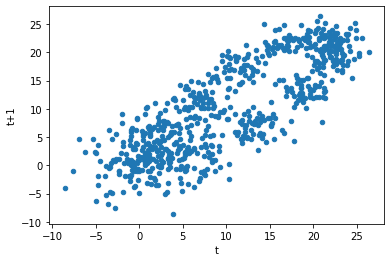

In [22]:
#lag
train['y(t+1)']=train.avg_temp.shift(-1)
ax=train.plot.scatter(x='avg_temp', y='y(t+1)')
ax.set(xlabel='t',ylabel='t+1')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

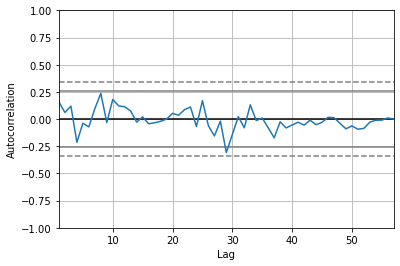

In [23]:
#auto correlation
pd.plotting.autocorrelation_plot(train.avg_temp.resample('Y').mean())

In [24]:
#drop from our train
train = train.drop(columns=['y(t+1)'])

## Modeling

Here are some of the functions I'm going to use. 

In [25]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

def make_predictions():
    '''
    make a prediction column
    '''
    yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

    return yhat_df

def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [26]:
# create an empty dataframe to store model type, our avg_temp, and its rmse.
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


### Last Observed Value

In [28]:
#the last observed value
temp=train['avg_temp'][-1:][0]
temp

15.932

In [29]:
#predictions based on last observed value
yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

yhat_df.head()

,avg_temp
date,
1956-11-01,15.932
1956-12-01,15.932
1957-01-01,15.932
1957-02-01,15.932
1957-03-01,15.932


avg_temp -- RMSE: 10


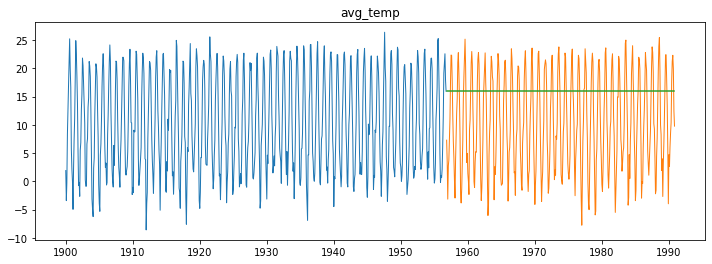

In [30]:
plot_and_eval('avg_temp')

In [31]:
eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,10.0


### Simple Average

In [32]:
# compute simple average/the mean of avergae temperatures
temp = round(train['avg_temp'].mean(),2)
temp

10.31

In [33]:
#predictions with simple average
yhat_df = pd.DataFrame({'avg_temp': [temp]},  
                      index = validate.index)

yhat_df.head()

,avg_temp
date,
1956-11-01,10.31
1956-12-01,10.31
1957-01-01,10.31
1957-02-01,10.31
1957-03-01,10.31


avg_temp -- RMSE: 8


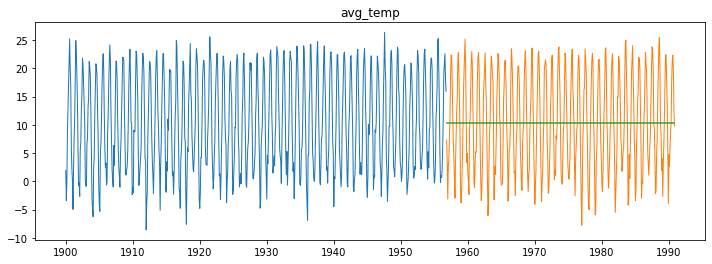

In [34]:
#visualize simple average predictions
plot_and_eval('avg_temp')

In [35]:
#append our simple averages RMSE to our evaluation dataframe
eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,10.0
1,simple_average,avg_temp,8.0


### Moving Average

In [36]:
#Let's look at the rolling average of 3 months 
period = 3

temp = round(train['avg_temp'].rolling(period).mean()[-1],2)
print(temp)

18.82


In [37]:
yhat_df = make_predictions()
yhat_df.head(2)

,avg_temp
date,
1956-11-01,18.82
1956-12-01,18.82


avg_temp -- RMSE: 12


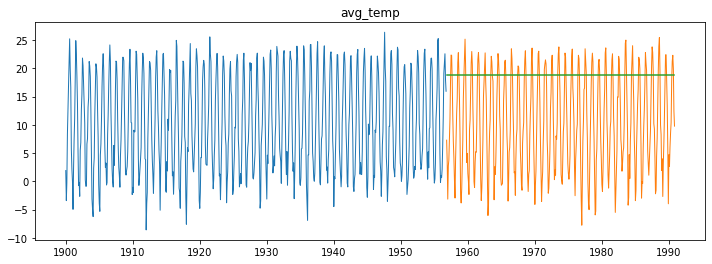

In [38]:
#visualize the rolling average of 3 months
plot_and_eval('avg_temp')

In [39]:
eval_df = append_eval_df(model_type = '3 month_moving_avg', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,10.0
1,simple_average,avg_temp,8.0
2,3 month_moving_avg,avg_temp,12.0


In [40]:
#let's test out 6 months, a year, a year and a half, 2 years, and 3 years for moving averages
periods = [6, 12, 18, 24, 36]

for p in periods: 
    temp = round(train['avg_temp'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions()
    model_type = str(p) + 'month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [41]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,10.0
1,simple_average,avg_temp,8.0
2,3 month_moving_avg,avg_temp,12.0
3,6month_moving_avg,avg_temp,11.0
4,12month_moving_avg,avg_temp,8.0
5,18month_moving_avg,avg_temp,9.0
6,24month_moving_avg,avg_temp,8.0
7,36month_moving_avg,avg_temp,8.0


In [42]:
# so far we have a nice tie going on here, let's keep pressing forward
min_temp_rmse = eval_df[eval_df.target_var=='avg_temp']['rmse'].min()

eval_df[eval_df.rmse==min_temp_rmse]

,model_type,target_var,rmse
1,simple_average,avg_temp,8.0
4,12month_moving_avg,avg_temp,8.0
6,24month_moving_avg,avg_temp,8.0
7,36month_moving_avg,avg_temp,8.0


### Holt's

In [43]:
for col in train.columns:
    model = Holt(train[col], exponential=False)
    model = model.fit(smoothing_level=0.1,
                      smoothing_slope = 0.1,
                      optimized=False)
    yhat_items = model.predict(start = validate.index[0],
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [44]:
#this model isn't going to help us much...
yhat_df

,avg_temp
date,
1956-11-01,12.85
1956-12-01,13.03
1957-01-01,13.22
1957-02-01,13.41
1957-03-01,13.59
...,...
1990-07-01,88.12
1990-08-01,88.31
1990-09-01,88.49


avg_temp -- RMSE: 47


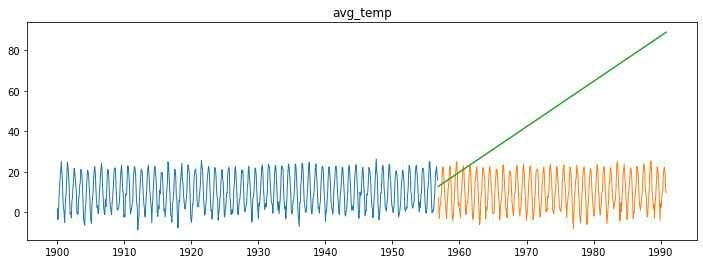

In [45]:
#visual proof
plot_and_eval('avg_temp')

In [46]:
#We might not have a winner here, but let's add it to the evaluation dataframe anyways.
eval_df = append_eval_df(model_type = 'holts_.1', 
                            target_var = col)
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
1,simple_average,avg_temp,8.0
4,12month_moving_avg,avg_temp,8.0
6,24month_moving_avg,avg_temp,8.0
7,36month_moving_avg,avg_temp,8.0
5,18month_moving_avg,avg_temp,9.0
0,last_observed_value,avg_temp,10.0
3,6month_moving_avg,avg_temp,11.0
2,3 month_moving_avg,avg_temp,12.0
8,holts_.1,avg_temp,47.0


In [47]:
#still a four way tie!
eval_df[eval_df.rmse==min_temp_rmse]

,model_type,target_var,rmse
1,simple_average,avg_temp,8.0
4,12month_moving_avg,avg_temp,8.0
6,24month_moving_avg,avg_temp,8.0
7,36month_moving_avg,avg_temp,8.0


### Based on Cycle

In [48]:
#these were my middle school years, so I thought it would be nice to use them as my train, validate, and test.
train = df[:'2010']
validate = df['2011']
test = df['2012']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

(1332, 1)
(12, 1)
(12, 1)


,avg_temp
date,
2010-08-01,24.948
2010-09-01,19.229
2010-10-01,14.582
2010-11-01,8.539
2010-12-01,-0.071


In [49]:
#our prediction will be a year added to train (2010)
yhat_df = train['2010'] + train.diff(12).mean()

In [50]:
#prediction vs actual value
pd.concat([yhat_df.head(1), validate.head(1)])

,avg_temp
date,
2010-01-01,-0.584224
2011-01-01,-1.582000


In [51]:
#set the indexes to each other
yhat_df.index = validate.index

avg_temp -- RMSE: 2


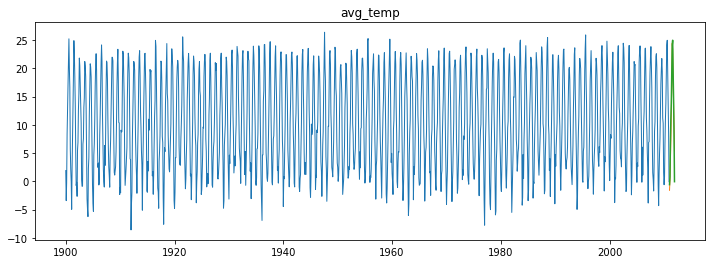

In [52]:
#visualize predictions based off previous year cycle
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

In [53]:
#let's see our evaluations
eval_df

,model_type,target_var,rmse
0,last_observed_value,avg_temp,10.0
1,simple_average,avg_temp,8.0
2,3 month_moving_avg,avg_temp,12.0
3,6month_moving_avg,avg_temp,11.0
4,12month_moving_avg,avg_temp,8.0
5,18month_moving_avg,avg_temp,9.0
6,24month_moving_avg,avg_temp,8.0
7,36month_moving_avg,avg_temp,8.0
8,holts_.1,avg_temp,47.0
9,previous_year,avg_temp,2.0


In [54]:
#let's predict 2012! 
yhat_df = validate + train.diff(12).mean()
yhat_df.index = test.index

In [55]:
#the rmse of the average temperature for our test, please.
rmse_temp = sqrt(mean_squared_error(test['avg_temp'], 
                                       yhat_df['avg_temp']))

In [56]:
print('rmse-temp: ', rmse_temp)

rmse-temp:  3.2467683418187048


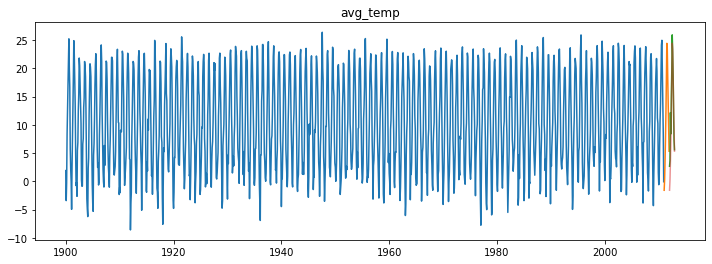

In [57]:
#look at final plot
for col in train.columns:
    final_plot(col)

In [58]:
#what if we predict 2013? The year I started playing tennis! 
yhat_df = test + train.diff(12).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

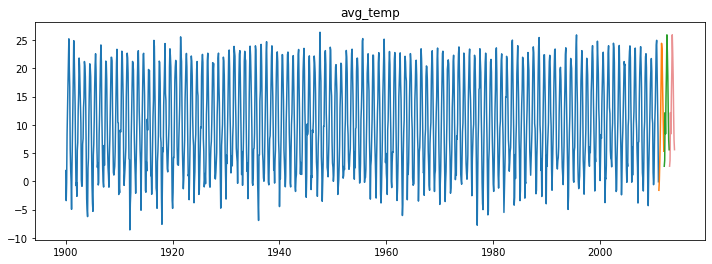

In [59]:
#final plot
final_plot(col)

# Conclusion:
 - Using the previous year's cycle worked better than using last observed value, simple average, moving average, and Holt's
 - Using previous year's cycle for test, I ended with an RMSE of 3.2
 
 - With more time, I'd like to look more into seasons
 - Look at other time series models
